In [2]:
%load_ext autoreload
%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from pathlib import Path

root_path = Path.cwd().parent.absolute()
import sys

sys.path.append(str(root_path))
import os


In [3]:
from flax import nnx
import jax
import jax.numpy as jnp

In [4]:
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.anderson_acceleration import anderson_method
from flows.gradient_flow import run_gradient_flow
from parametric_model.parametric_model import ParametricModel

# Define parametric model in $d = 2$

In [20]:
# Define the parametric model
dim = 2
parametric_model = ParametricModel(
    parametric_map="node",  # "node" "resnet"
    rhs_model="mlp",  # "mlp" or "resnet"
    architecture=[dim, 2, 16],  # [input_dim, num_layers, hidden_width]
    activation_fn="tanh",  # "tanh", "relu", "SinTu", "identity", "sigmoid", "gelu", "swish"
    time_dependent=True,  # True or False
    solver="euler",  # "euler" or "heun"
    dt0=0.01, 
    ref_density="gaussian",
    scale_factor=2e-1,
)
_, init_params  = nnx.split(parametric_model)
init_params = jax.tree.map(lambda _x: _x, init_params)

In [6]:
key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)

In [7]:
G_mat_flow = G_matrix(parametric_model)
solver = "cg"  # minres or cg

# Define the $\operatorname{KL}$ minimization problem by choosing the target functional

In [8]:
case = 'double banana' # 'gaussian' | 'double banana'

## Gaussian setup

In [9]:
from functionals.functions import get_gaussian_potential
if case == 'gaussian':
    mean = jnp.full((dim,), 1.0)
    sigma_inv = jnp.diag(jnp.array([10., 0.1]))
    potential_fn = get_gaussian_potential(mean, sigma_inv)

    # Anderson parameters
    h = 1e-1  # Time step size
    m = 6  # Number of previous iterates to consider
    beta = 1.25  # Damping parameter
    max_iterations = 300
    tolerance = 1e-4
    n_samples = 3_000  # Monte Carlo sample size

## Double-banana setup

In [21]:
if case == 'double banana':
    from jax.scipy.special import logsumexp
    from functools import partial

    def potential_fn_double_banana(x, shift):
        x -= shift[..., :]
        x1 = x[..., 0]
        
        log_density = 2.*(jnp.linalg.norm(x, axis=-1) - 3.) ** 2
        log_density -= logsumexp(jnp.stack([-2.*(x1 - 3.)**2, -2.*(x1 + 3.)**2], axis=-1), axis=-1)
        return log_density
        
    potential_fn = partial(potential_fn_double_banana, shift=jnp.array([0., 0.]))
    # Anderson parameters
    h = 1e-1  # Time step size
    m = 6  # Number of previous iterates to consider
    beta = 1.25  # Damping parameter
    l2_reg_gamma = 1. # l2 regularization of mixing parameters Gamma
    max_iterations = 300
    tolerance = 1e-4
    n_samples = 3_000  # Monte Carlo sample size

Define the $\operatorname{KL}$ functional (i.e. linear + entropy with equal coef.)

In [11]:
linear_potential = LinearPotential(potential_fn=potential_fn, coeff=1.)
internal_potential = InternalPotential(
    functional="entropy", coeff=1.0, method="exact", prob_dim=dim
)

potential = Potential(
    linear=linear_potential, internal=internal_potential, interaction=None
)

Generate reference sample with Picard method

Gradient Flow Progress:   0%|                                                                                                                                  | 0/299 [00:00<?, ?it/s]/home/aksenov/Documents/code/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  Tk_under = jnp.zeros((k + 1, k), dtype=jnp.float64)
/home/aksenov/Documents/code/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:131: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See

Iter 150: Energy = -1.986237, Grad norm: 6.50e-01


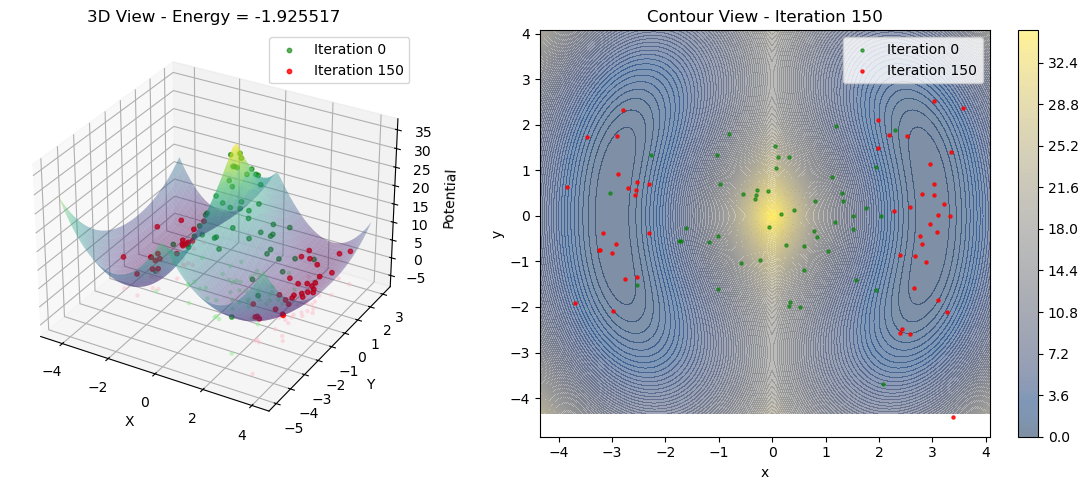

Gradient Flow Progress: 100%|██████████████████████████████████████████▊| 298/299 [38:00<00:07,  7.39s/it, Energy=-2.034920, Linear=0.866815, Internal=-2.901735, Interaction=0.000000]

Iter 298: Energy = -2.034920, Grad norm: 2.09e+00


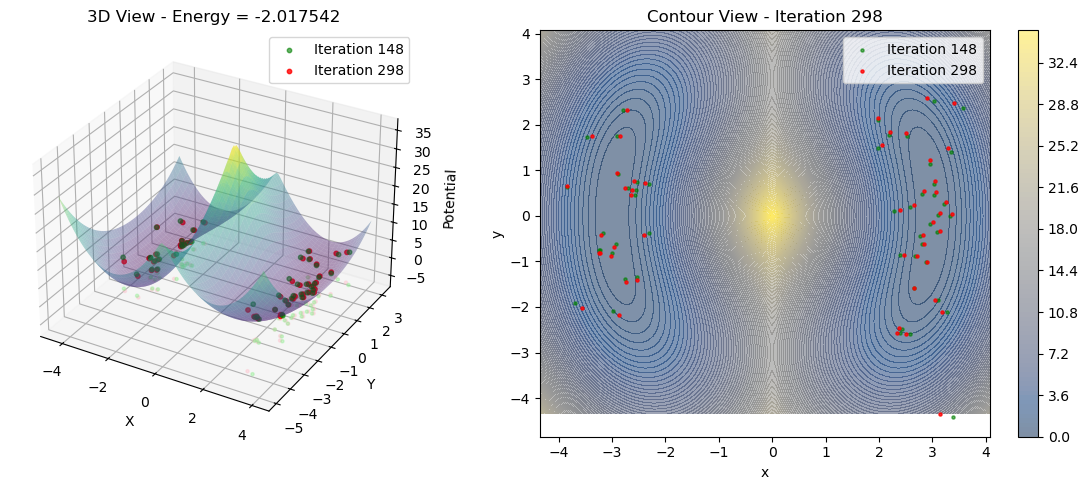

Gradient Flow Progress: 100%|███████████████████████████████████████████| 299/299 [38:02<00:00,  7.63s/it, Energy=-2.034920, Linear=0.866815, Internal=-2.901735, Interaction=0.000000]


=== Integration Complete ===
Total iterations:    298
Initial energy:      14.298025
Final energy:        -2.034920
Total decrease:      16.332945
Reduction ratio:     -0.1423
Final param norm:    4.531760


In [12]:
key, subkey = jax.random.split(key)
# <<test dataset>>
z_samples = jax.random.normal(
    subkey,
    (50, 2),
)

history_gd = run_gradient_flow(
    parametric_model,
    z_samples,
    G_mat_flow,
    potential,
    N_samples=n_samples,
    max_iterations=max_iterations,
    h=h,
    progress_every=max_iterations//2,
)

In [13]:
final_model = history_gd.pop('final_parametric_model')
pot = history_gd.pop('potential')

In [14]:
import pickle
import time

timestamp = time.strftime("%d.%m.%Y_%H:%M.%S")

with open(f'./{timestamp}_gf_{case}.pkl', 'wb') as ofile:
    pickle.dump(history_gd, ofile)

In [22]:
cp_anderson, history_anderson = anderson_method(parametric_model, 
                                       n_samples, 
                                       z_samples, 
                                       G_mat_flow, 
                                       potential,
                                       initial_params=init_params,
                                       n_iterations=max_iterations, 
                                       step_size=h, 
                                       memory_size=m, 
                                       relaxation=beta, 
                                       l2_reg_gamma=l2_reg_gamma,)

Starting Anderson-accelerated gradient flow
  n_iterations: 300
  step_size: 0.1
  memory_size: 6
  mixing_parameter: 1.25
------------------------------------------------------------


/home/aksenov/Documents/code/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  Tk_under = jnp.zeros((k + 1, k), dtype=jnp.float64)
/home/aksenov/Documents/code/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:131: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rhs = jnp.zeros((k + 1,), dtype=jnp.float64).at[0].set(beta1)


Iter    0 | Energy: 1.082856e+01 | Residual: 1.263718e+00 | 
Iter    1 | Energy: 2.279367e+00 | Residual: 1.063223e-01 | 
Iter    2 | Energy: 1.697157e+00 | Residual: 9.528886e-02 | 
Iter    3 | Energy: 1.224026e+00 | Residual: 1.301292e-01 | 
Iter    4 | Energy: 6.690083e-01 | Residual: 1.662177e-01 | 
Iter   10 | Energy: -1.115449e+00 | Residual: 3.469866e-02 | 
Iter   20 | Energy: -1.413477e+00 | Residual: 5.384739e-03 | 
Iter   30 | Energy: -1.501897e+00 | Residual: 4.428054e-03 | 
Iter   40 | Energy: -1.666420e+00 | Residual: 1.310126e-02 | 
Iter   50 | Energy: -1.727314e+00 | Residual: 4.242291e-03 | 
Iter   60 | Energy: -1.798238e+00 | Residual: 9.389879e-03 | 
Iter   70 | Energy: -1.841712e+00 | Residual: 3.271496e-03 | 
Iter   80 | Energy: -1.865554e+00 | Residual: 2.394035e-03 | 
Iter   90 | Energy: -1.902188e+00 | Residual: 2.542772e-03 | 
Iter  100 | Energy: -1.916863e+00 | Residual: 5.866358e-03 | 
Iter  110 | Energy: -1.951496e+00 | Residual: 6.958687e-03 | 
Iter  120 | E

In [16]:

with open(f'./{timestamp}_am_{case}.pkl', 'wb') as ofile:
    pickle.dump(history_anderson, ofile)


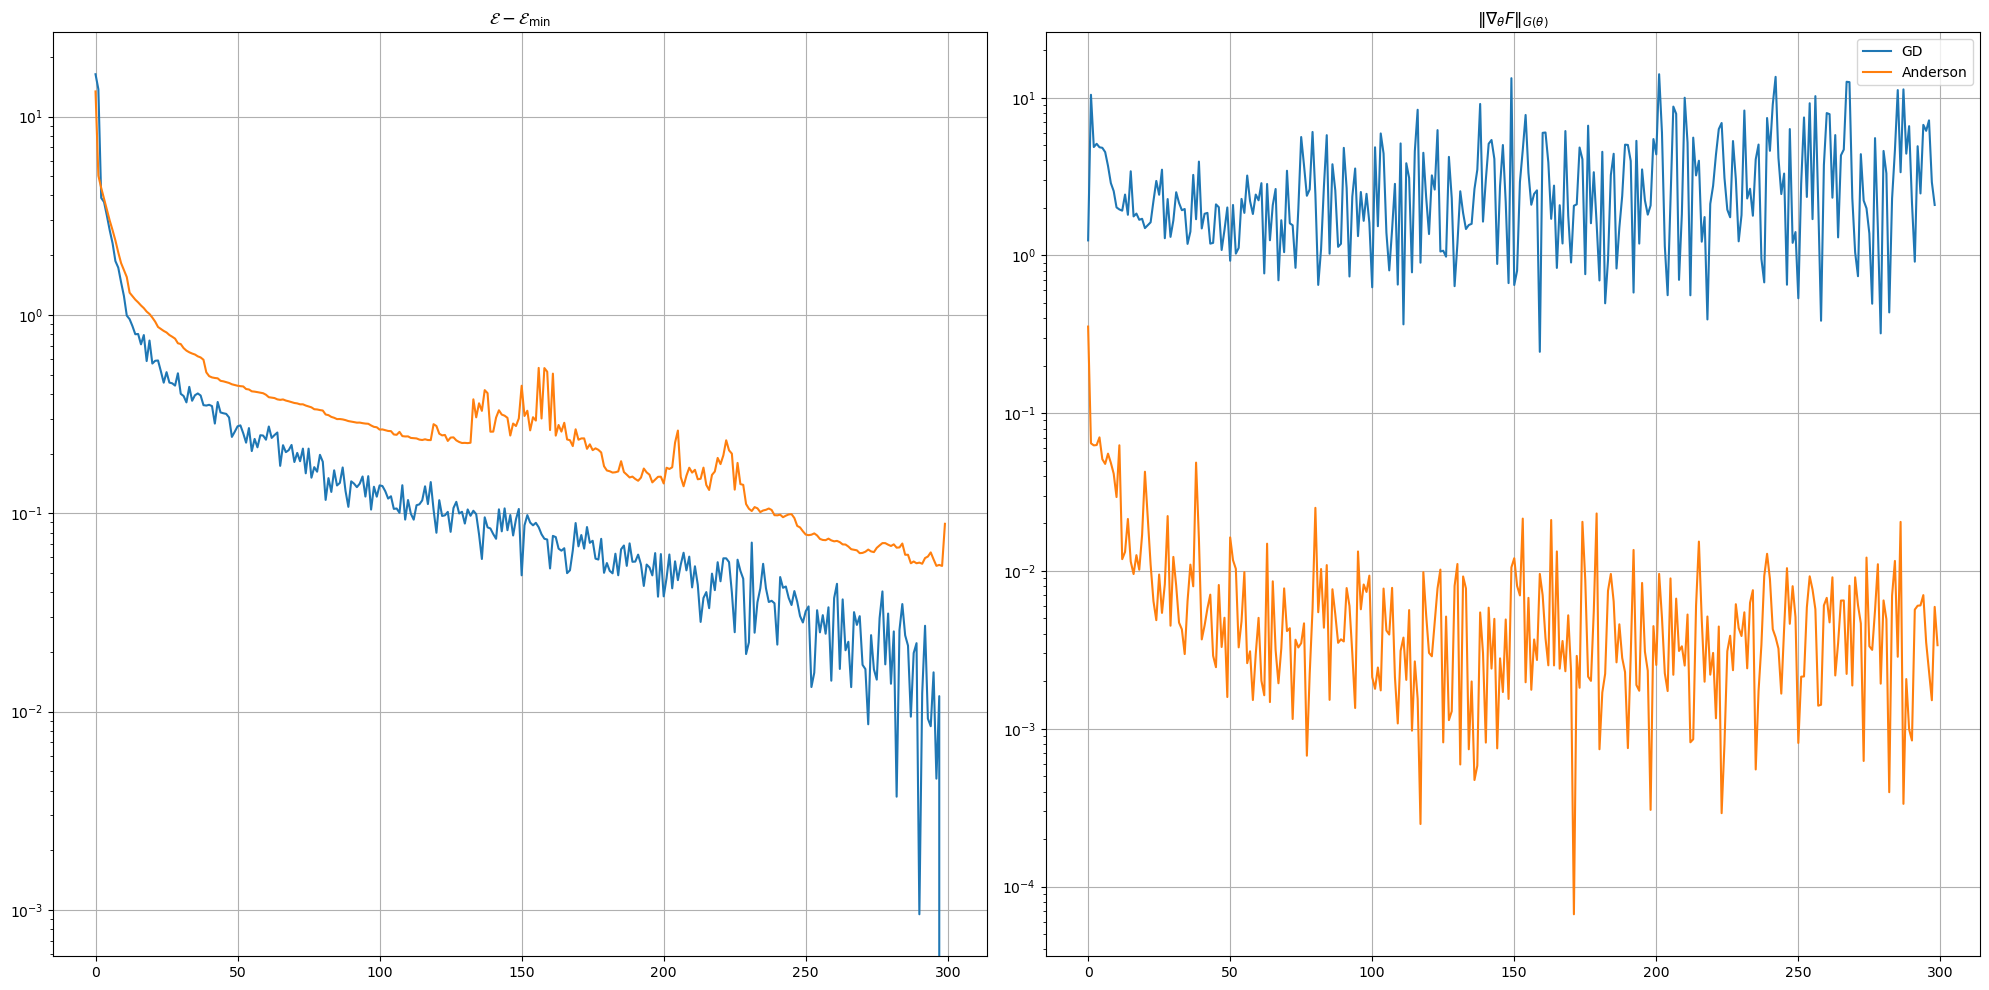

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20,10))
ax = axs[0]
e_gd = history_gd["energy_history"]
e_gd = jnp.array(e_gd)
e_am = history_anderson["energies"]
e_am = jnp.array(e_am)
e_min = jnp.min(jnp.concatenate((e_gd, e_am))) - 1e-10
e_gd -= e_min  # so that we can safely plot in log scale
e_am -= e_min
ax.plot(e_gd, label='GD')
ax.plot(e_am, label='Anderson')
ax.set_yscale("log")
# ax.set_ylim(1e-2, None)
ax.grid()
ax.set_title(r'$\mathcal{E} - \mathcal{E}_{\text{min}}$')

ax = axs[1]

ax.plot(history_gd['riemann_grad_norm_history'], label='GD')
ax.plot(history_anderson['riemann_grad_history'], label='Anderson')
ax.set_yscale('log')
ax.grid()
ax.set_title(r"$\| \nabla_\theta F\|_{G(\theta)}$")

# ax = axs[2]
# ax.plot(history['euclid_grad_norm_history'], label='GD')
# ax.set_yscale('log')
# ax.grid()
# ax.set_title(r"$\| \nabla_\theta F\|_2$")

axs[-1].legend()
fig.tight_layout()
fig.savefig('GD_vs_AM.pdf')

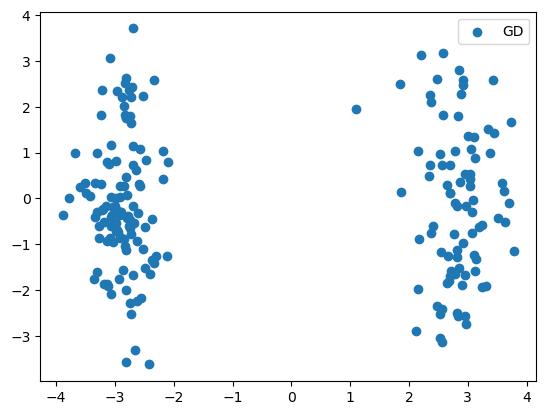

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, shape=(200, 2))

gd, _ = nnx.split(parametric_model)
# model_am = nnx.merge(gd, cp_anderson)
z_samples = jax.random.normal(subkey, shape=(200, 2))
# sample_am = model_am(z_samples)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, shape=(200, 2))
sample_gd = final_model(z_samples)


ax.scatter(*sample_gd.T, label='GD')
# ax.scatter(*sample_am.T, label='AM')
ax.legend()

In [19]:
sample_gd = history_gd['sample_history'][-1]
jnp.mean(sample_am, axis=0), jnp.linalg.inv(jnp.cov(sample_am.T, ))

NameError: name 'sample_am' is not defined